In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, leaves_list
import numpy as np

In [5]:
#load the datasets

socioeconomic_df = pd.read_csv("./Data/socioeconomic_dataset.csv")
health_burden_df = pd.read_csv("./Data/health_burden_dataset.csv")
risk_factors_df = pd.read_csv("./Data/risk_factor_dataset.csv")

In [6]:
risk_factors_df.head()

measure location                                  cause  \
0  Deaths  Morocco  Chronic obstructive pulmonary disease   
1  Deaths  Morocco  Chronic obstructive pulmonary disease   
2  Deaths  Morocco  Chronic obstructive pulmonary disease   
3  Deaths  Morocco  Chronic obstructive pulmonary disease   
4  Deaths  Morocco  Chronic obstructive pulmonary disease   

               risk_factor  metric  year         val  
0  Ambient ozone pollution  Number  2000  257.840865  
1  Ambient ozone pollution  Number  2001  249.595886  
2  Ambient ozone pollution  Number  2002  245.426604  
3  Ambient ozone pollution  Number  2003  268.556783  
4  Ambient ozone pollution  Number  2004  298.192621

In [7]:
# Standardize column names for consistency
socioeconomic_df.rename(columns={'Country': 'country', 'Year': 'year'}, inplace=True)
health_burden_df.rename(columns={'location': 'country'}, inplace=True)
risk_factors_df.rename(columns={'location': 'country'}, inplace=True)

In [8]:
# Step 2: Normalize text values for merging
socioeconomic_df['country'] = socioeconomic_df['country'].str.strip().str.lower()
health_burden_df['country'] = health_burden_df['country'].str.strip().str.lower()
risk_factors_df['country'] = risk_factors_df['country'].str.strip().str.lower()

In [9]:
# Step 3: Subset COPD-specific rows from burden and risk datasets
copd_burden_df = health_burden_df[
    health_burden_df['cause'].str.contains("chronic obstructive pulmonary disease", case=False)
].copy()

copd_risk_df = risk_factors_df[
    risk_factors_df['cause'].str.contains("chronic obstructive pulmonary disease", case=False)
].copy()


# copd_burden_df.to_csv("burden_risk.csv", index=False)

In [10]:
# Step 4: Pivot health burden data to wide format ---
burden_pivot = copd_burden_df.pivot_table(
    index=['country', 'year'],
    columns='measure',
    values='val',
    aggfunc='mean'
).reset_index()

# Fill NaN values with 0 and convert all numeric columns to integers
for col in burden_pivot.columns[2:]:  # Skip first three columns (country, year, measure)
    burden_pivot[col] = burden_pivot[col].fillna(0).astype(int)

# Rename risk_factor columns by flattening the MultiIndex (if any)
burden_pivot.columns.name = None  # Remove the column index name
burden_pivot = burden_pivot.rename(columns=lambda x: x.replace(" ", "_").lower() if isinstance(x, str) else x)

# Display the modified dataframe
print(burden_pivot.head())

# burden_pivot.to_csv("burden_risk.csv", index=False)

   country  year  dalys_(disability-adjusted_life_years)  deaths  incidence  \
0  algeria  2000                                   76462    2493      28242   
1  algeria  2001                                   78867    2558      29540   
2  algeria  2002                                   82146    2656      31153   
3  algeria  2003                                   85619    2775      32909   
4  algeria  2004                                   89019    2884      34679   

   prevalence  ylds_(years_lived_with_disability)  ylls_(years_of_life_lost)  
0      408840                               25101                      51360  
1      426458                               26172                      52695  
2      447935                               27464                      54682  
3      471288                               28878                      56740  
4      494937                               30304                      58715  


In [11]:

# Pivot the dataset to align risk factors as columns
risk_pivot = copd_risk_df.pivot_table(
    index=['country', 'year', 'measure'],
    columns='risk_factor',
    values='val',
    aggfunc='mean'
).reset_index()

# Fill NaN values with 0 and convert all numeric columns to integers
for col in risk_pivot.columns[3:]:  # Skip first three columns (country, year, measure)
    risk_pivot[col] = risk_pivot[col].fillna(0).astype(int)

# Rename risk_factor columns by flattening the MultiIndex (if any)
risk_pivot.columns.name = None  # Remove the column index name
risk_pivot = risk_pivot.rename(columns=lambda x: x.replace(" ", "_").lower() if isinstance(x, str) else x)

# Pivoting the 'measure' column to create separate columns for each measure
df_risk_wide = risk_pivot.pivot(index=["country", "year"], columns="measure")

# Flattening multi-level column names
df_risk_wide.columns = ['_'.join(col).strip() for col in df_risk_wide.columns.values]

# Resetting index to make 'country' and 'year' regular columns again
df_risk_wide.reset_index(inplace=True)

# Dictionary for renaming columns concisely
rename_dict = {
    "ambient_ozone_pollution_DALYs (Disability-Adjusted Life Years)": "ozone_DALY",
    "ambient_ozone_pollution_Deaths": "ozone_DTH",
    "ambient_ozone_pollution_YLDs (Years Lived with Disability)": "ozone_YLD",
    "ambient_ozone_pollution_YLLs (Years of Life Lost)": "ozone_YLL",
    "ambient_particulate_matter_pollution_DALYs (Disability-Adjusted Life Years)": "pm25_DALY",
    "ambient_particulate_matter_pollution_Deaths": "pm25_DTH",
    "ambient_particulate_matter_pollution_YLDs (Years Lived with Disability)": "pm25_YLD",
    "ambient_particulate_matter_pollution_YLLs (Years of Life Lost)": "pm25_YLL",
    "household_air_pollution_from_solid_fuels_DALYs (Disability-Adjusted Life Years)": "household_pollution_DALY",
    "household_air_pollution_from_solid_fuels_Deaths": "household_pollution_DTH",
    "household_air_pollution_from_solid_fuels_YLDs (Years Lived with Disability)": "household_pollution_YLD",
    "household_air_pollution_from_solid_fuels_YLLs (Years of Life Lost)": "household_pollution_YLL",
    "secondhand_smoke_DALYs (Disability-Adjusted Life Years)": "shs_DALY",
    "secondhand_smoke_Deaths": "shs_DTH",
    "secondhand_smoke_YLDs (Years Lived with Disability)": "shs_YLD",
    "secondhand_smoke_YLLs (Years of Life Lost)": "shs_YLL",
    "smoking_DALYs (Disability-Adjusted Life Years)": "smoking_DALY",
    "smoking_Deaths": "smoking_DTH",
    "smoking_YLDs (Years Lived with Disability)": "smoking_YLD",
    "smoking_YLLs (Years of Life Lost)": "smoking_YLL"
}

# Renaming columns
df_risk_wide.rename(columns=rename_dict, inplace=True)


df_risk_wide

# risk_pivot.to_csv("risk_pivot.csv", index=False)

country  year  ozone_DALY  ozone_DTH  ozone_YLD  ozone_YLL  pm25_DALY  \
0      algeria  2000        7397        370          0       7397      18436   
1      algeria  2001        7436        372          0       7436      18957   
2      algeria  2002        7089        354          0       7089      19589   
3      algeria  2003        7197        362          0       7197      20220   
4      algeria  2004        7528        380          0       7528      20763   
...        ...   ...         ...        ...        ...        ...        ...   
1183  zimbabwe  2017        2144         97          0       2144       3206   
1184  zimbabwe  2018        2161         97          0       2161       3147   
1185  zimbabwe  2019        2255        101          0       2255       3153   
1186  zimbabwe  2020        2338        105          0       2338       3370   
1187  zimbabwe  2021        2390        105          0       2390       3208   

      pm25_DTH  pm25_YLD  pm25_YLL  ...  household_pollution_YLD  \
0          626      5923     12513  ...                      231   
1          640      6159     12797  ...                      215   
2          659      6419     13170  ...                      195   
3          681      6686     13534  ...                      174   
4          698      6935     13827  ...                      153   
...        ...       ...       ...  ...                      ...   
1183       107       812      2393  ...                     6636   
1184       105       805      2341  ...                     6875   
1185       104       816      2337  ...                     7108   
1186       111       881      2488  ...                     7204   
1187       102       855      2352  ...                     7482   

      household_pollution_YLL  shs_DALY  shs_DTH  shs_YLD  shs_YLL  \
0                         465      6768      214     2291     4477   
1                         424      6985      220     2385     4600   
2                         382      7288      228     2507     4781   
3                         336      7612      239     2638     4973   
4                         290      7934      249     2774     5159   
...                       ...       ...      ...      ...      ...   
1183                    18292      2530       74      766     1764   
1184                    18715      2603       76      794     1808   
1185                    19061      2670       77      824     1846   
1186                    18998      2713       78      847     1866   
1187                    19253      2764       77      876     1887   

      smoking_DALY  smoking_DTH  smoking_YLD  smoking_YLL  
0            26109         1003         7020        19088  
1            26770         1020         7323        19447  
2            27734         1052         7672        20062  
3            28835         1086         8056        20779  
4            29823         1120         8426        21397  
...            ...          ...          ...          ...  
1183         13501          491         2777        10724  
1184         13824          499         2870        10954  
1185         14113          507         2963        11150  
1186         14225          507         3020        11205  
1187         14173          491         3064        11109  

[1188 rows x 22 columns]

In [12]:
# Step 6: Merge all datasets on 'country' and 'year' 
merged_df = socioeconomic_df.merge(burden_pivot, on=['country', 'year'], how='left')
merged_df = merged_df.merge(df_risk_wide, on=['country', 'year'], how='left')

# Preview the final merged dataset
print("Merged DataFrame shape:", merged_df.shape)
print(merged_df.head())

merged_df
merged_df.to_csv("merged_burden_risk.csv", index=False)

Merged DataFrame shape: (1040, 43)
   country       Sub-Region  year  Population  GDP PER CAPITA (USD)  \
0  algeria  Northern Africa  2000    30774621               1780.38   
1  algeria  Northern Africa  2001    31200985               1754.58   
2  algeria  Northern Africa  2002    31624696               1794.81   
3  algeria  Northern Africa  2003    32055883               2117.05   
4  algeria  Northern Africa  2004    32510186               2624.80   

   Area (Km2)  Population Density  Total CO2 Emission excluding LUCF (Mt)  \
0     2381741           12.921061                                   80.05   
1     2381741           13.100075                                   78.65   
2     2381741           13.277974                                   82.40   
3     2381741           13.459013                                   88.19   
4     2381741           13.649757                                   89.49   

   Nitrogen Oxide  Sulphur Dioxide  ...  household_pollution_YLD  \
0      

### Columns definition

**Country:** *Name of the country.*

**Sub-Region:** *Geographic sub‐region to which the country belongs.*

**Year:** *The calendar year for which the data is recorded.*

**Population:** *Total number of people residing in the country for that year.*

**GDP per Capita:** *Gross domestic product per person in the country for that year.*

**Area:** *Total land area of the country (likely in square kilometers).*

**Population Density:** *Number of people per unit area (e.g., population per square kilometer).*

**Total CO₂ Emission excluding LUCF:** *Total carbon dioxide emissions (in million tonnes), excluding those from land‐use change and forestry (LUCF).*

**Nitrogen Oxide:** *Annual nitrogen oxide (NOx) emissions (in tonnes).*

**Sulphur Dioxide:** *Annual sulfur dioxide (SO₂) emissions (in tonnes).*

**Carbon Monoxide:** *Annual carbon monoxide (CO) emissions (in tonnes).*

**Organic Carbon:** *Annual organic carbon emissions (in tonnes).*

**NMVOC:** *Annual non‐methane volatile organic compound emissions (in tonnes).*

**Black Carbon:** *Annual black carbon emissions (in tonnes).*

**Ammonia:** *Annual ammonia (NH₃) emissions (in tonnes).*

**Chronic_Respiratory(RSD):** *Risk‐standardized death rate for chronic respiratory diseases.*

**HAQ_Index (Healthcare Access and Quality Index):** *Composite score reflecting the coverage and quality of healthcare services.*

**dalys_(disability-adjusted_life_years):** *Total disability‐adjusted life years lost to COPD (chronic obstructive pulmonary disease).*

**Deaths:** *Number of deaths attributable to COPD.*

**Incidence:** *Number of new COPD cases occurring during the specified year.*

**Prevalence:** *Total number of existing COPD cases (new or previously diagnosed) in that year.*

**ylds_(years_lived_with_disability):** *Years lived with disability due to COPD.*

**ylls_(years_of_life_lost):** *Years of life lost due to premature mortality from COPD.*

**ozone_DALY:** *Disability‐adjusted life years lost to COPD associated with ambient ozone pollution.*

**ozone_DTH:** *Number of COPD deaths attributed to ambient ozone pollution.*

**ozone_YLD:** *Years lived with disability due to COPD from ambient ozone pollution.*

**ozone_YLL:** *Years of life lost to COPD from ambient ozone pollution.*

**pm25_DALY:** *Disability‐adjusted life years lost to COPD from exposure to ambient PM2.5 (fine particulate matter).*

**pm25_DTH:** *Number of COPD deaths from ambient PM2.5 exposure.*

**pm25_YLD:** *Years lived with disability due to COPD from ambient PM2.5 exposure.*

**pm25_YLL:** *Years of life lost to COPD from ambient PM2.5 exposure.*

**household_pollution_DALY:** *Disability‐adjusted life years lost to COPD from household air pollution (solid fuels).*

**household_pollution_DTH:** *Number of COPD deaths from household air pollution (solid fuels).*

**household_pollution_YLD:** *Years lived with disability due to COPD from household air pollution (solid fuels).*

**household_pollution_YLL:** *Years of life lost to COPD from household air pollution (solid fuels).*

**shs_DALY:** *Disability‐adjusted life years lost to COPD from secondhand smoke.*

**shs_DTH:** *Number of COPD deaths attributed to secondhand smoke.*

**shs_YLD:** *Years lived with disability due to COPD from secondhand smoke.*

**shs_YLL:** *Years of life lost to COPD from secondhand smoke.*

**smoking_DALY:** *Disability‐adjusted life years lost to COPD from active smoking.*

**smoking_DTH:** *Number of COPD deaths attributable to active smoking.*

**smoking_YLD:** *Years lived with disability due to COPD from active smoking.*

**smoking_YLL:** *Years of life lost to COPD from active smoking.*

In [13]:
# Ensure proper year formatting
merged_df['year'] = merged_df['year'].astype(int)

# # Create DALYs Metric
# merged_df['DALYs'] = merged_df[['Deaths', 'YLLs (Years of Life Lost)', 'YLDs (Years Lived with Disability)']].sum(axis=1)

# merged_df.head()

In [14]:

#Missing Data Summary
# ----------------------------
missing_data_pct = (merged_df.isna().mean() * 100).sort_values(ascending=False)

print(missing_data_pct)

HAQ_Index                                 95.288462
Chronic_Respiratory(RSD)                  95.288462
ozone_YLD                                  5.769231
incidence                                  5.769231
prevalence                                 5.769231
ylds_(years_lived_with_disability)         5.769231
ylls_(years_of_life_lost)                  5.769231
dalys_(disability-adjusted_life_years)     5.769231
deaths                                     5.769231
ozone_DTH                                  5.769231
ozone_DALY                                 5.769231
shs_DALY                                   5.769231
shs_DTH                                    5.769231
shs_YLD                                    5.769231
shs_YLL                                    5.769231
household_pollution_DALY                   5.769231
household_pollution_DTH                    5.769231
household_pollution_YLD                    5.769231
household_pollution_YLL                    5.769231
smoking_DALY

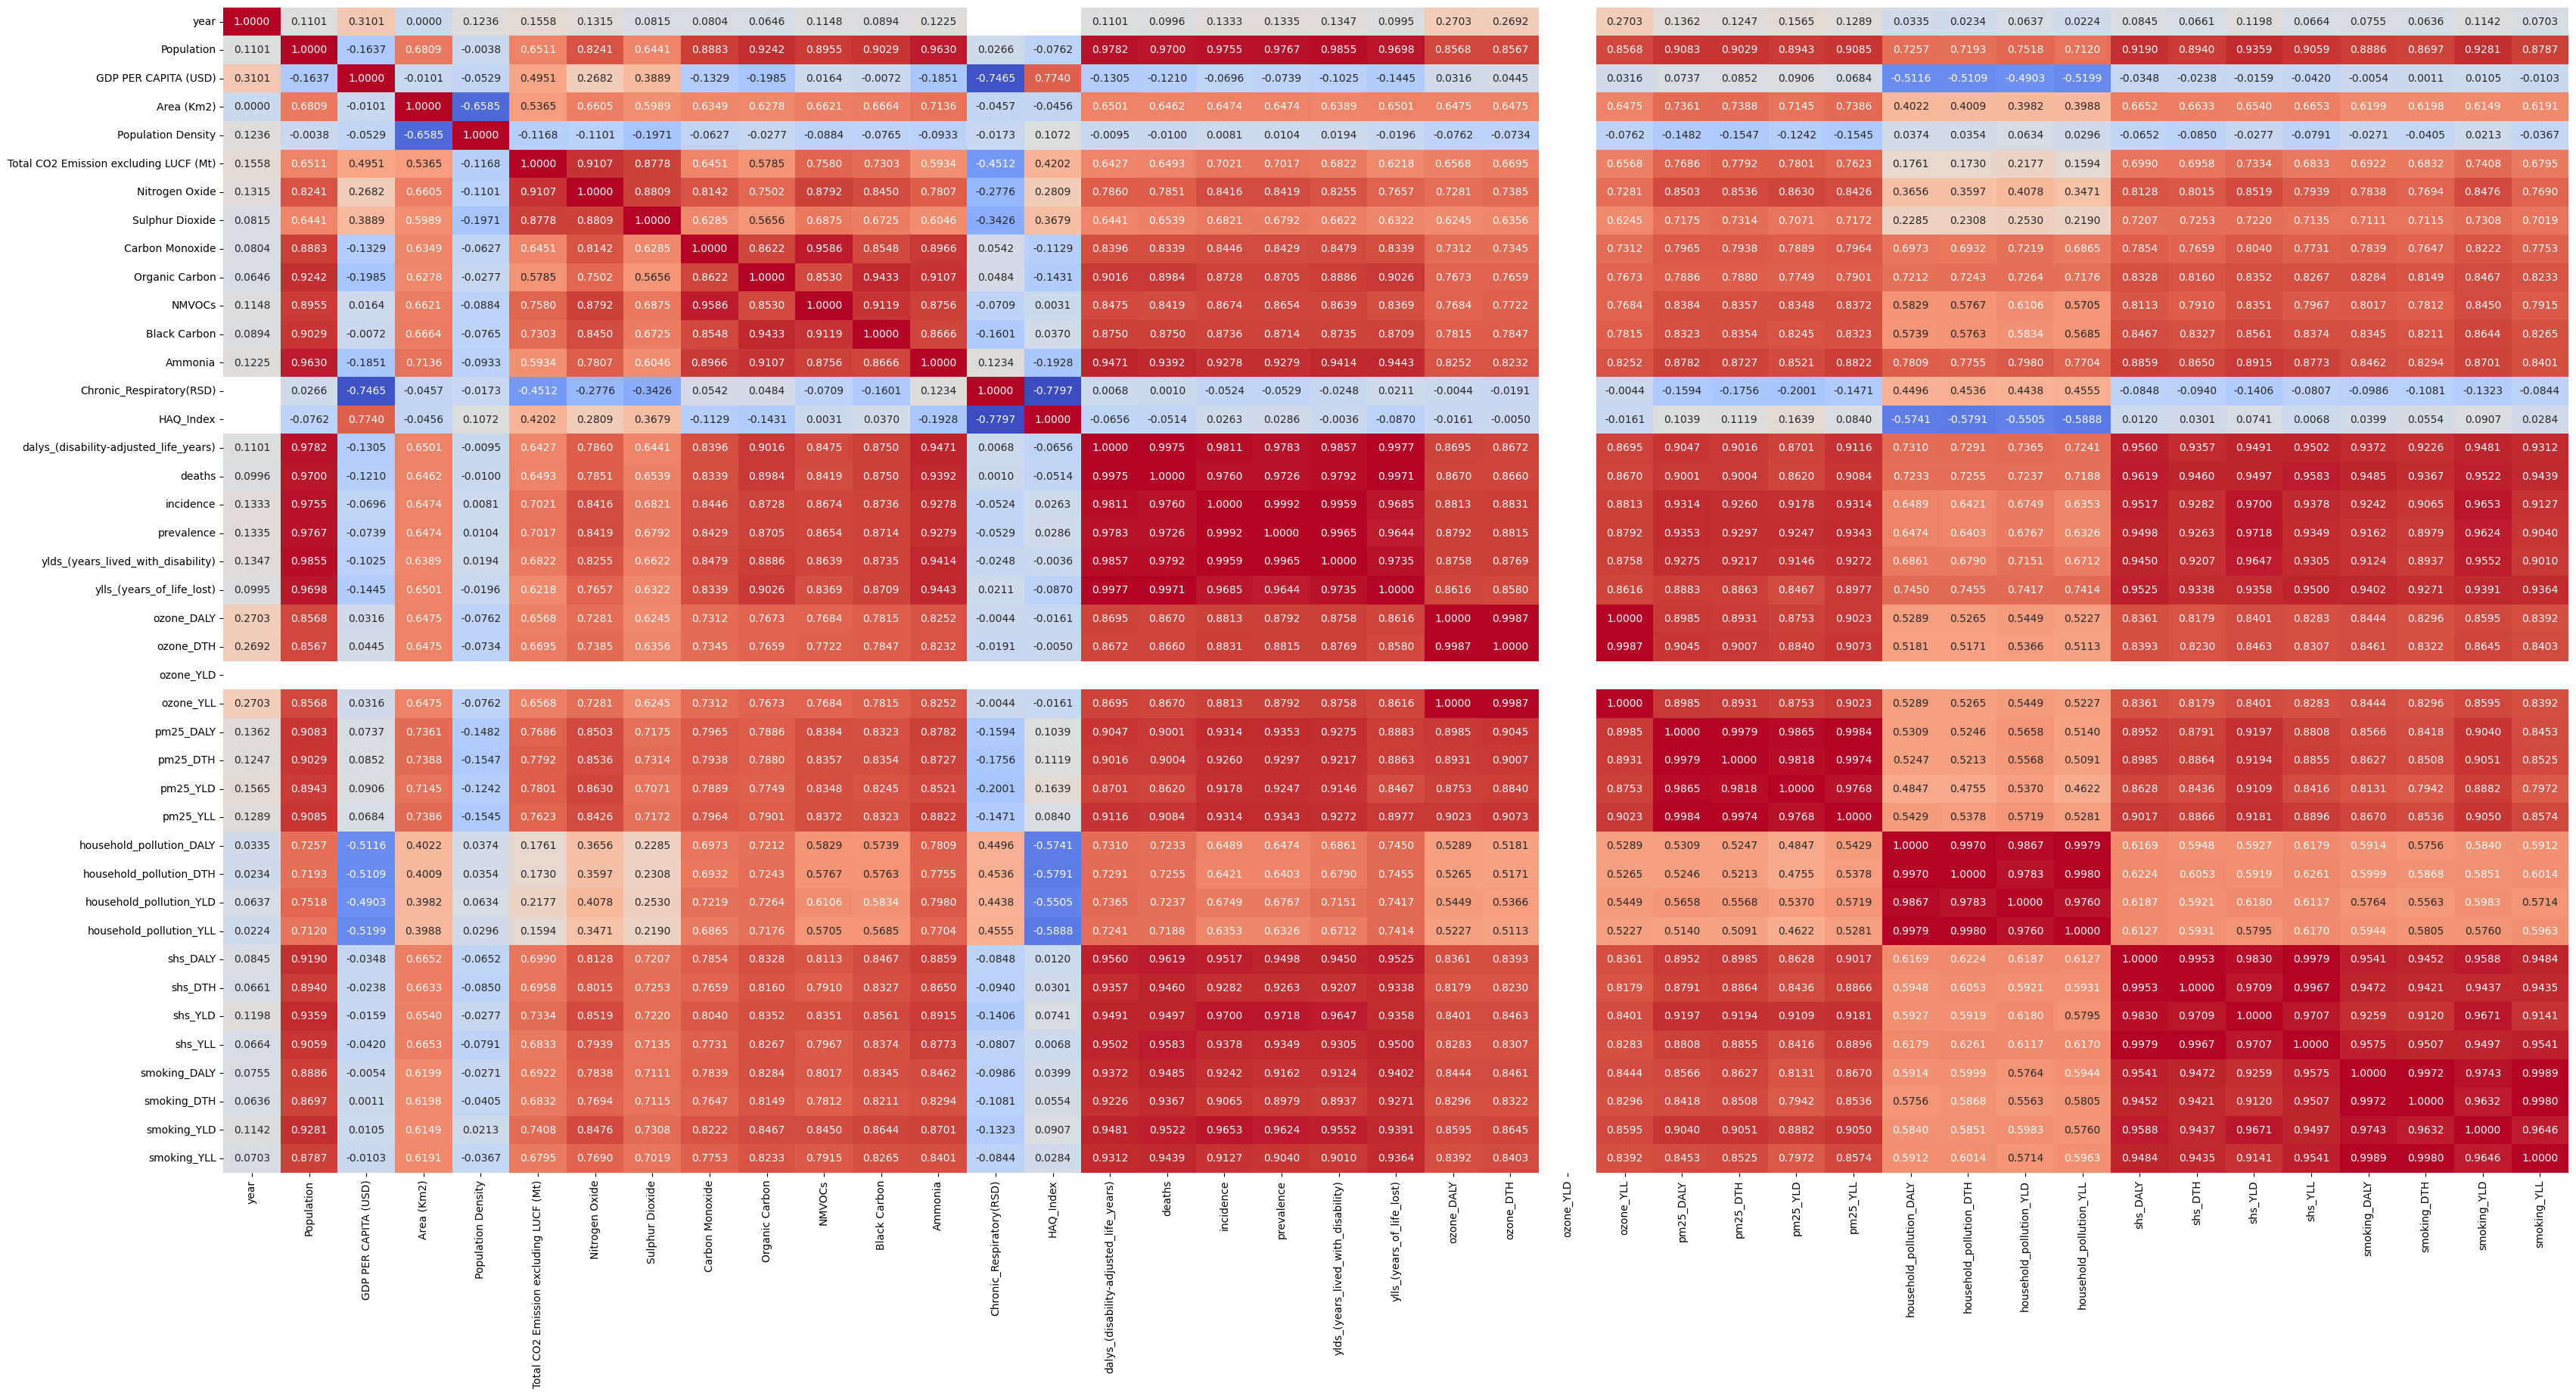

In [15]:
# Correlation Matrix
eda_numeric = merged_df.select_dtypes(include=['float64', 'int64'])
eda_corr = eda_numeric.corr(method='spearman')

# Plot heatmap
fig, ax = plt.subplots(figsize=(40, 20))
sns.heatmap(eda_corr, annot=True, fmt='.4f', 
            cmap='coolwarm', cbar=False, ax=ax)

# Adjust y-axis labels
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

# Save figure
#plt.savefig('result.png', bbox_inches='tight', pad_inches=0.0)
plt.show()

##############################################################################
### Formulas & Explanations
##############################################################################

#### 1) Pearson Correlation Coefficient r(X,Y):
#####       r(X,Y) = Cov(X,Y) / (StdDev(X) * StdDev(Y))
#####       where Cov(X,Y) = E[(X - E[X]) * (Y - E[Y])]
#####       By default, df.corr() in pandas uses Pearson correlation.

#### 2) Distance for Hierarchical Clustering (for reordering):
#####       distance = 1 - |r|
#####       Here, r is the correlation between two variables.
#####       We take the absolute value |r| so that strongly
#####       positive or negative correlations produce small distances
#####       and thus get clustered together.

#### 3) Hierarchical Clustering:
#####       Z = linkage(distance_matrix, method="ward")
#####       This uses Ward's method (minimizing variance within clusters)
#####       to cluster variables based on the distance metric above.

In [16]:


def normalize_decade_columns(df, cols_to_normalize, method="zscore"):
    """
    Normalizes specified columns in-place.
    By default (method="zscore"), each column is transformed:
       z = (x - mean) / std
    """
    for col in cols_to_normalize:
        if col not in df.columns:
            continue
        series = df[col].dropna()
        if series.empty or series.std() == 0:
            continue
        if method == "zscore":
            mean_val = series.mean()
            std_val = series.std()
            df[col] = df[col].apply(
                lambda x: (x - mean_val) / std_val if pd.notnull(x) else x
            )
        elif method == "minmax":
            min_val, max_val = series.min(), series.max()
            df[col] = df[col].apply(
                lambda x: (x - min_val) / (max_val - min_val) if pd.notnull(x) else x
            )
    return df

def cluster_and_plot_corr(df_sub, title="Correlation Heatmap", vmin=-1, vmax=1):
    """
    1) Computes Spearman correlation among columns of df_sub.
    2) Converts correlation to distance = 1 - |r|, handles non-finite as 0.
    3) Performs Ward’s hierarchical clustering.
    4) Reorders columns accordingly and plots an annotated heatmap (coolwarm).
    """
    df_clean = df_sub.dropna(axis=0)
    if df_clean.empty:
        print(f"[Warning] '{title}' skipped (no valid rows).")
        return
    
    # Drop constant columns
    constant_cols = [c for c in df_clean.columns if df_clean[c].std() == 0]
    if constant_cols:
        df_clean = df_clean.drop(columns=constant_cols)
    
    if df_clean.shape[1] < 2:
        print(f"[Warning] '{title}' skipped (fewer than 2 columns).")
        return

    # Spearman correlation
    corr = df_clean.corr(method="spearman")
    distance_matrix = 1 - np.abs(corr.values)
    distance_matrix[~np.isfinite(distance_matrix)] = 0  # fix non-finite

    try:
        Z = linkage(distance_matrix, method="ward")
    except ValueError as e:
        print(f"[Error] Clustering failed for '{title}': {e}")
        return

    optimal_order = leaves_list(Z)
    corr_reordered = corr.values[optimal_order, :][:, optimal_order]
    col_labels = corr.columns[optimal_order]

    plt.figure(figsize=(20, 10))
    plt.imshow(corr_reordered, vmin=vmin, vmax=vmax, cmap="coolwarm")
    cbar = plt.colorbar()
    cbar.set_label("Spearman Correlation Coefficient")

    plt.xticks(range(len(col_labels)), col_labels, rotation=90)
    plt.yticks(range(len(col_labels)), col_labels)

    # Annotate each cell
    for i in range(len(col_labels)):
        for j in range(len(col_labels)):
            val = corr_reordered[i, j]
            plt.text(j, i, f"{val:.2f}", ha="center", va="center", fontsize=7)
    
    plt.title(title)
    plt.tight_layout()
    plt.show()

def generate_eight_correlation_plots(merged_df):
    """
    1) Normalizes HAQ_Index and Chronic_Respiratory(RSD).
    2) Produces eight correlation plots focusing on:
       (1) Risk Factors vs. Disease Burden
       (2) Emissions vs. Disease Burden
       (3) Demographics vs. Disease Burden
       (4) Ozone vs. Disease Burden
       (5) PM2.5 vs. Disease Burden
       (6) Household Pollution vs. Disease Burden
       (7) Secondhand Smoke vs. Disease Burden
       (8) Smoking vs. Disease Burden
    """
    # Normalize columns recorded in decades
    merged_df = normalize_decade_columns(
        merged_df,
        cols_to_normalize=["HAQ_Index", "Chronic_Respiratory(RSD)"],
        method="zscore"
    )

    # Disease Burden columns
    disease_burden_cols = [
        "Chronic_Respiratory(RSD)",
        "dalys_(disability-adjusted_life_years)",
        "deaths",
        "incidence",
        "prevalence",
        "ylds_(years_lived_with_disability)",
        "ylls_(years_of_life_lost)"
    ]

    # Risk Factors
    ozone_cols = ["ozone_DALY", "ozone_DTH", "ozone_YLD", "ozone_YLL"]
    pm25_cols = ["pm25_DALY", "pm25_DTH", "pm25_YLD", "pm25_YLL"]
    household_cols = [
        "household_pollution_DALY", "household_pollution_DTH",
        "household_pollution_YLD", "household_pollution_YLL"
    ]
    shs_cols = ["shs_DALY", "shs_DTH", "shs_YLD", "shs_YLL"]
    smoking_cols = ["smoking_DALY", "smoking_DTH", "smoking_YLD", "smoking_YLL"]
    risk_factor_cols = ozone_cols + pm25_cols + household_cols + shs_cols + smoking_cols

    # Emissions
    emission_cols = [
        "Total CO2 Emission excluding LUCF (Mt)",
        "Nitrogen Oxide",
        "Sulphur Dioxide",
        "Carbon Monoxide",
        "Organic Carbon",
        "NMVOCs",
        "Black Carbon",
        "Ammonia"
    ]

    # Demographics
    demographic_cols = [
        "Population",
        "GDP PER CAPITA (USD)",
        "Area (Km2)",
        "Population Density"
    ]

    # 1) Risk Factors vs. Disease Burden
    cluster_and_plot_corr(
        merged_df[risk_factor_cols + disease_burden_cols],
        title="(1) Risk Factors vs. Disease Burden"
    )
    
    # 2) Emissions vs. Disease Burden
    cluster_and_plot_corr(
        merged_df[emission_cols + disease_burden_cols],
        title="(2) Emissions vs. Disease Burden"
    )
    
    # 3) Demographics vs. Disease Burden
    cluster_and_plot_corr(
        merged_df[demographic_cols + disease_burden_cols],
        title="(3) Demographics vs. Disease Burden"
    )
    
    # 4) Ozone vs. Disease Burden
    cluster_and_plot_corr(
        merged_df[ozone_cols + disease_burden_cols],
        title="(4) Ozone vs. Disease Burden"
    )
    
    # 5) PM2.5 vs. Disease Burden
    cluster_and_plot_corr(
        merged_df[pm25_cols + disease_burden_cols],
        title="(5) PM2.5 vs. Disease Burden"
    )
    
    # 6) Household Pollution vs. Disease Burden
    cluster_and_plot_corr(
        merged_df[household_cols + disease_burden_cols],
        title="(6) Household Pollution vs. Disease Burden"
    )
    
    # 7) Secondhand Smoke vs. Disease Burden
    cluster_and_plot_corr(
        merged_df[shs_cols + disease_burden_cols],
        title="(7) Secondhand Smoke vs. Disease Burden"
    )
    
    # 8) Smoking vs. Disease Burden
    cluster_and_plot_corr(
        merged_df[smoking_cols + disease_burden_cols],
        title="(8) Smoking vs. Disease Burden"
    )



/var/folders/pr/tggh7p7s6pv8q1386lq2xmn40000gn/T/ipykernel_1739/269709756.py:53: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(distance_matrix, method="ward")


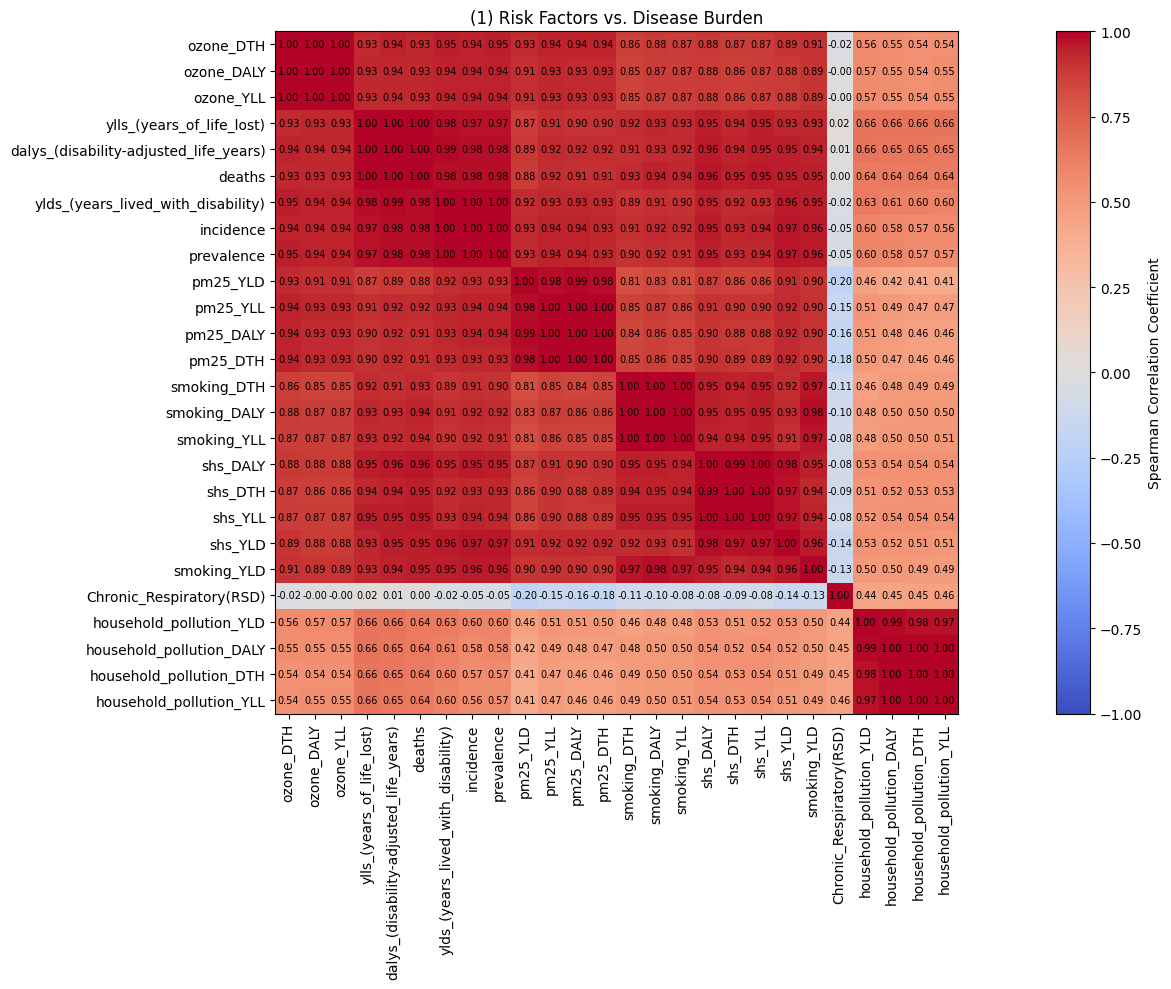

/var/folders/pr/tggh7p7s6pv8q1386lq2xmn40000gn/T/ipykernel_1739/269709756.py:53: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(distance_matrix, method="ward")


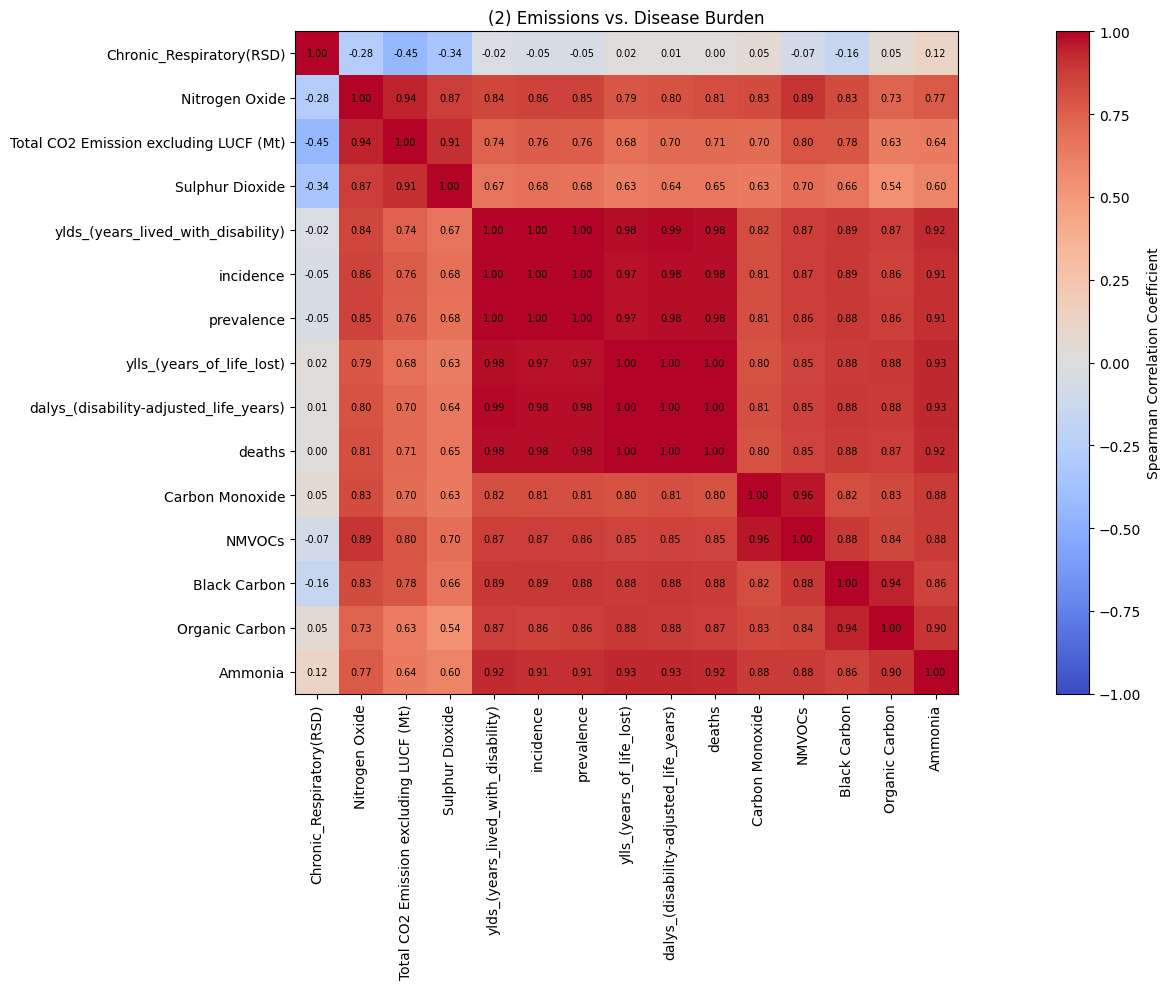

/var/folders/pr/tggh7p7s6pv8q1386lq2xmn40000gn/T/ipykernel_1739/269709756.py:53: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(distance_matrix, method="ward")


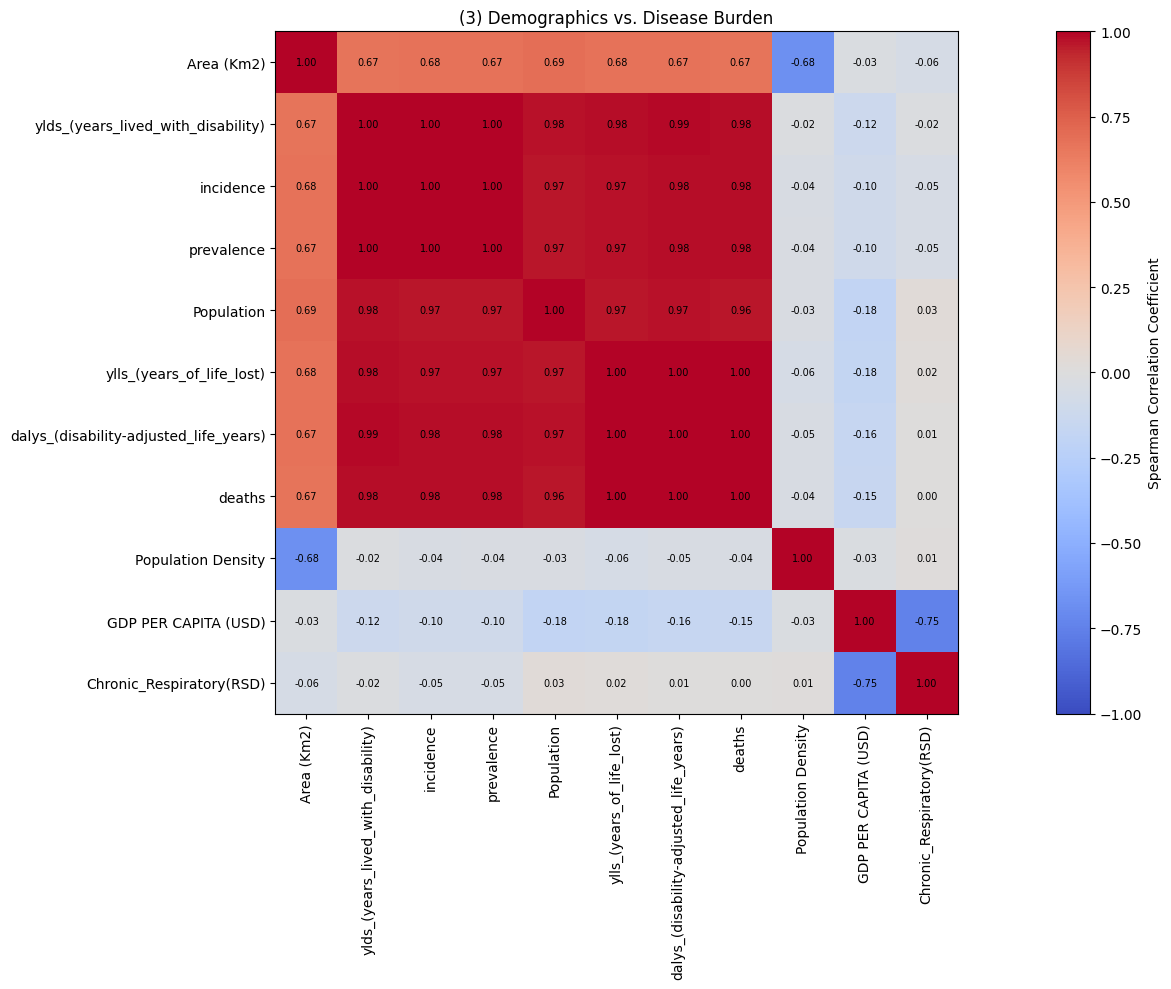

/var/folders/pr/tggh7p7s6pv8q1386lq2xmn40000gn/T/ipykernel_1739/269709756.py:53: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(distance_matrix, method="ward")


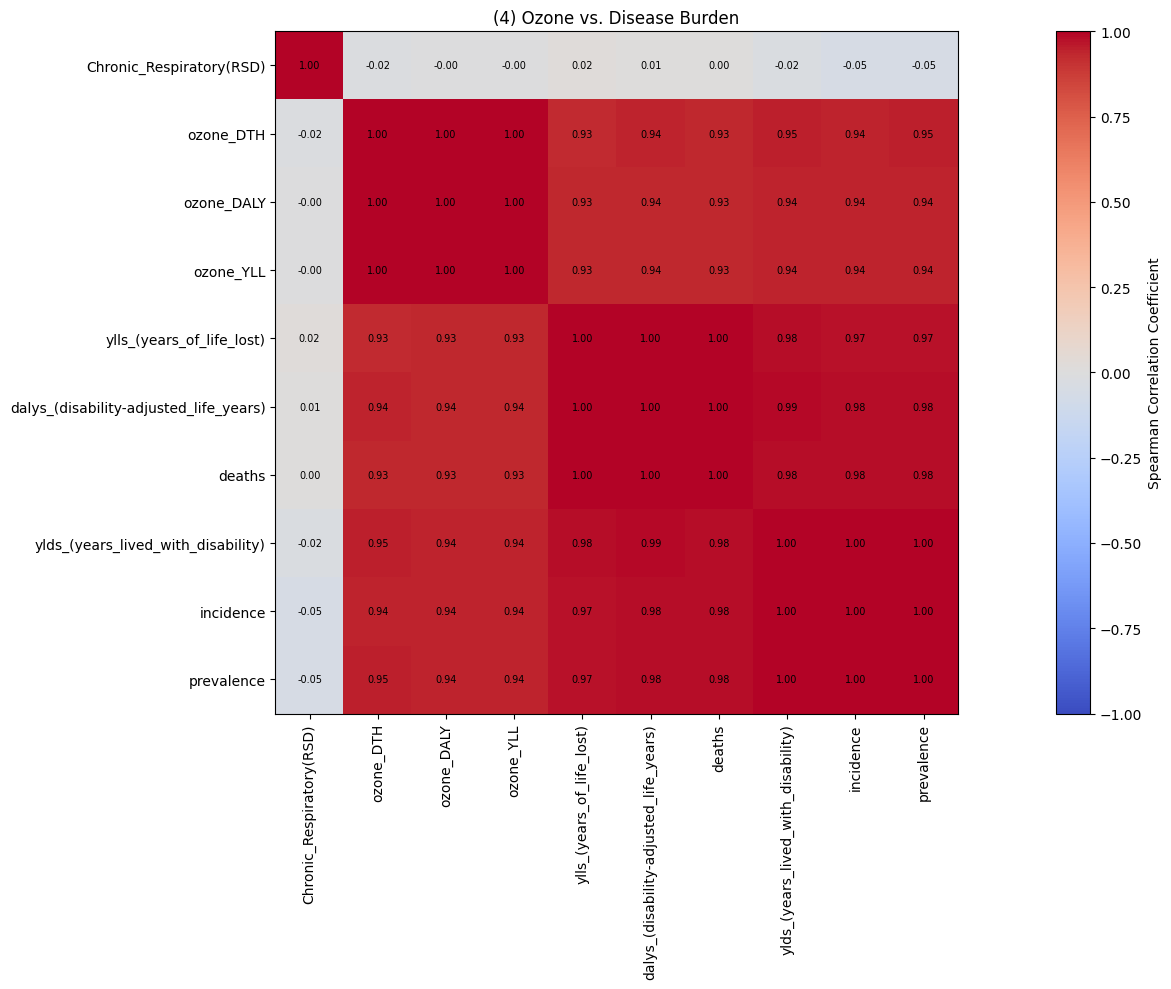

/var/folders/pr/tggh7p7s6pv8q1386lq2xmn40000gn/T/ipykernel_1739/269709756.py:53: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(distance_matrix, method="ward")


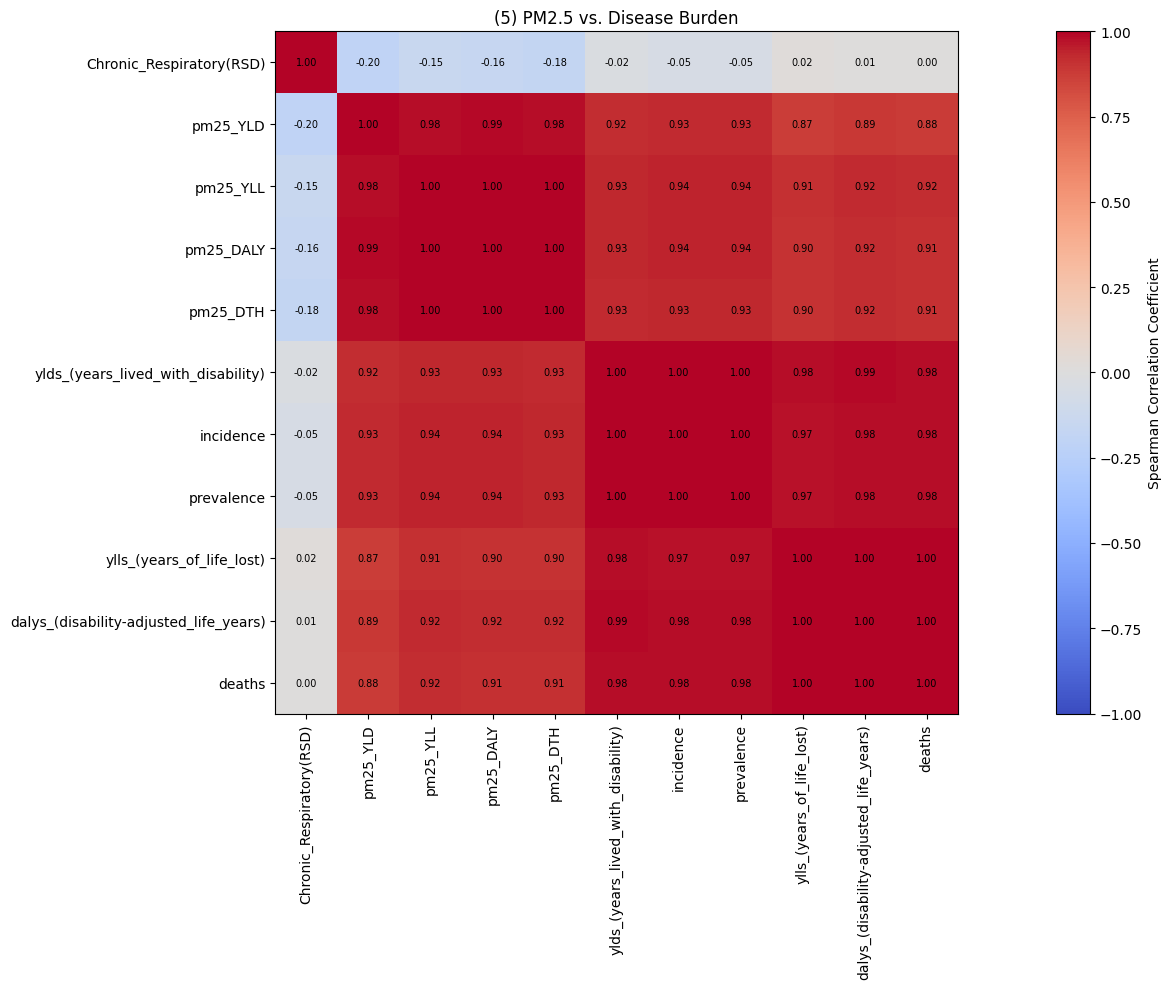

/var/folders/pr/tggh7p7s6pv8q1386lq2xmn40000gn/T/ipykernel_1739/269709756.py:53: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(distance_matrix, method="ward")


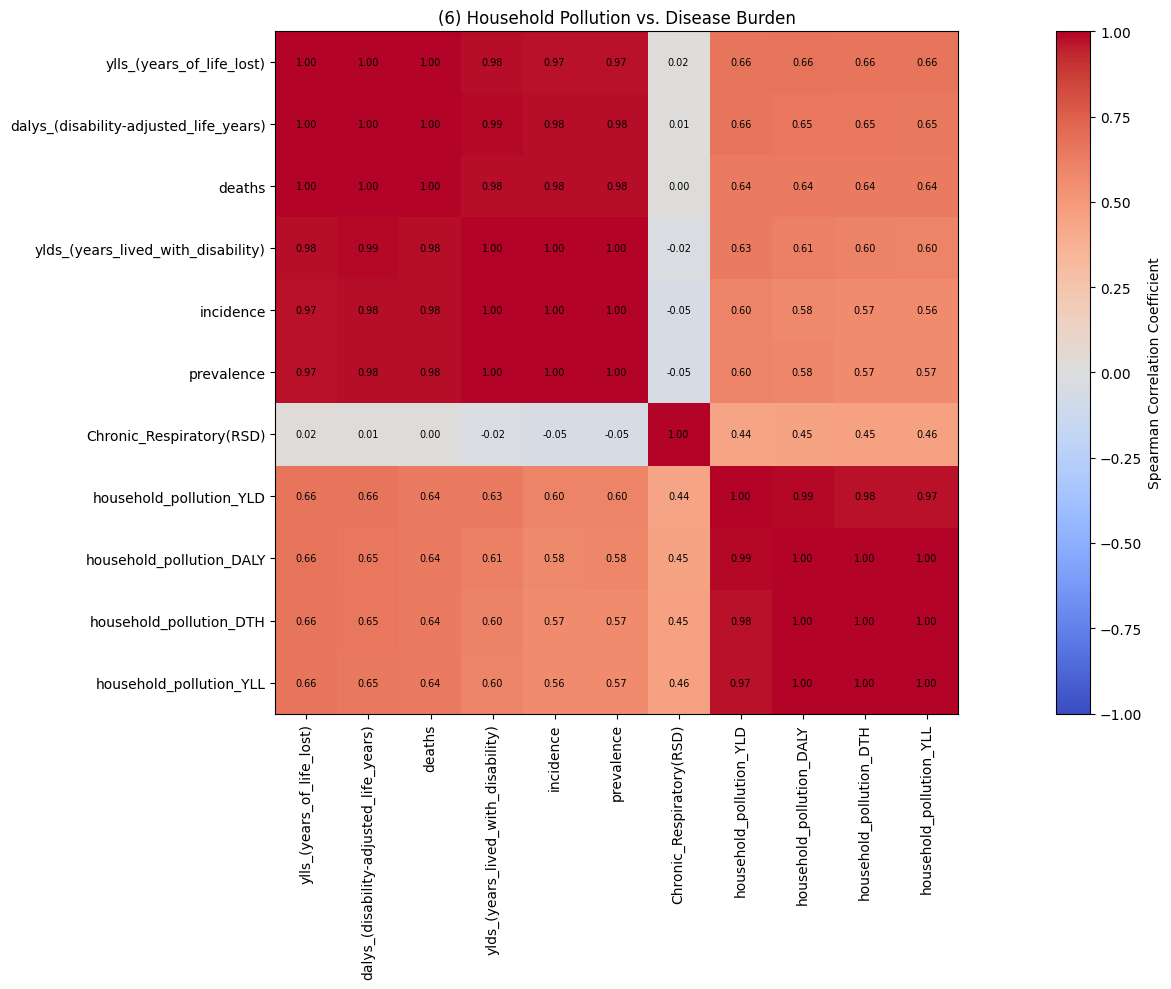

/var/folders/pr/tggh7p7s6pv8q1386lq2xmn40000gn/T/ipykernel_1739/269709756.py:53: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(distance_matrix, method="ward")


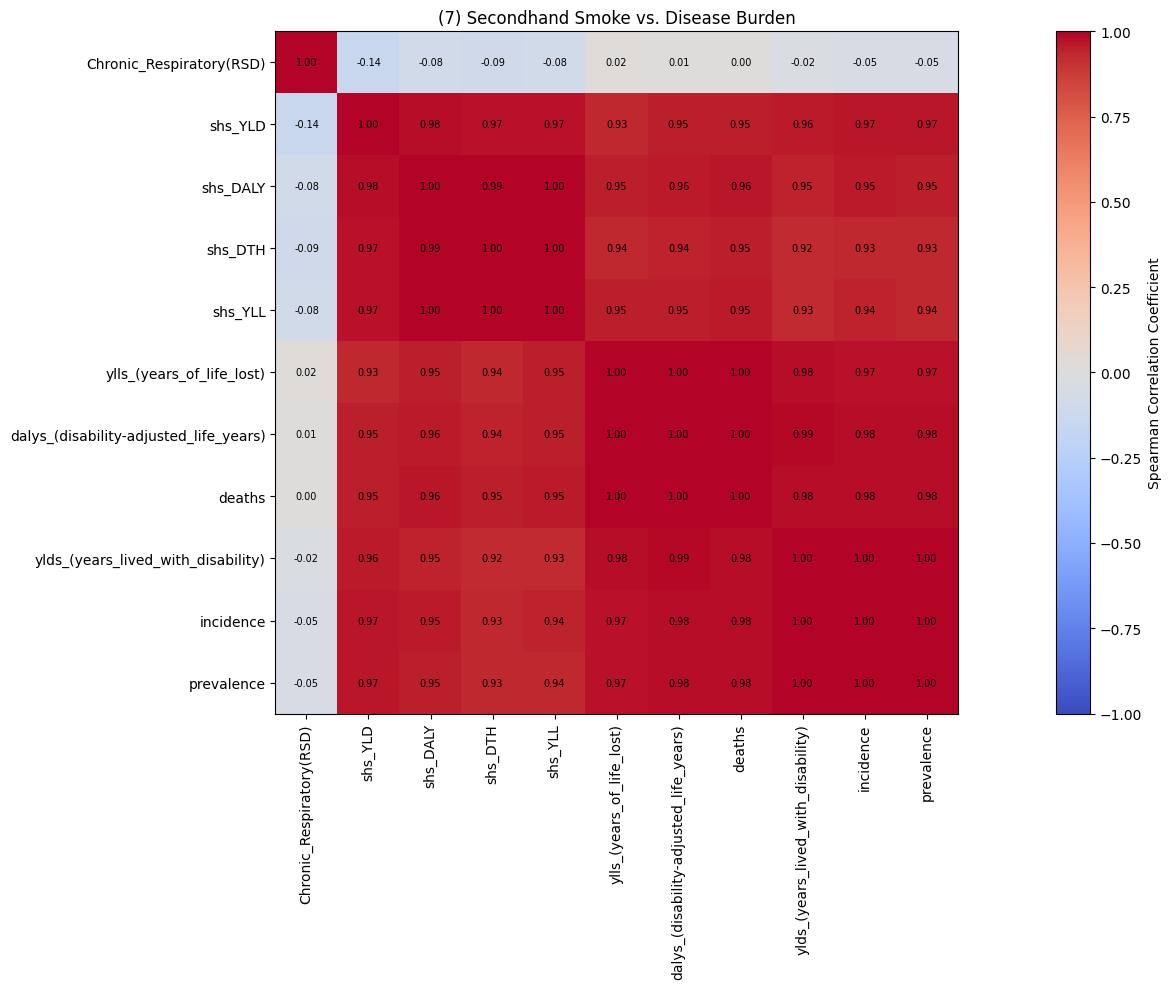

/var/folders/pr/tggh7p7s6pv8q1386lq2xmn40000gn/T/ipykernel_1739/269709756.py:53: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(distance_matrix, method="ward")


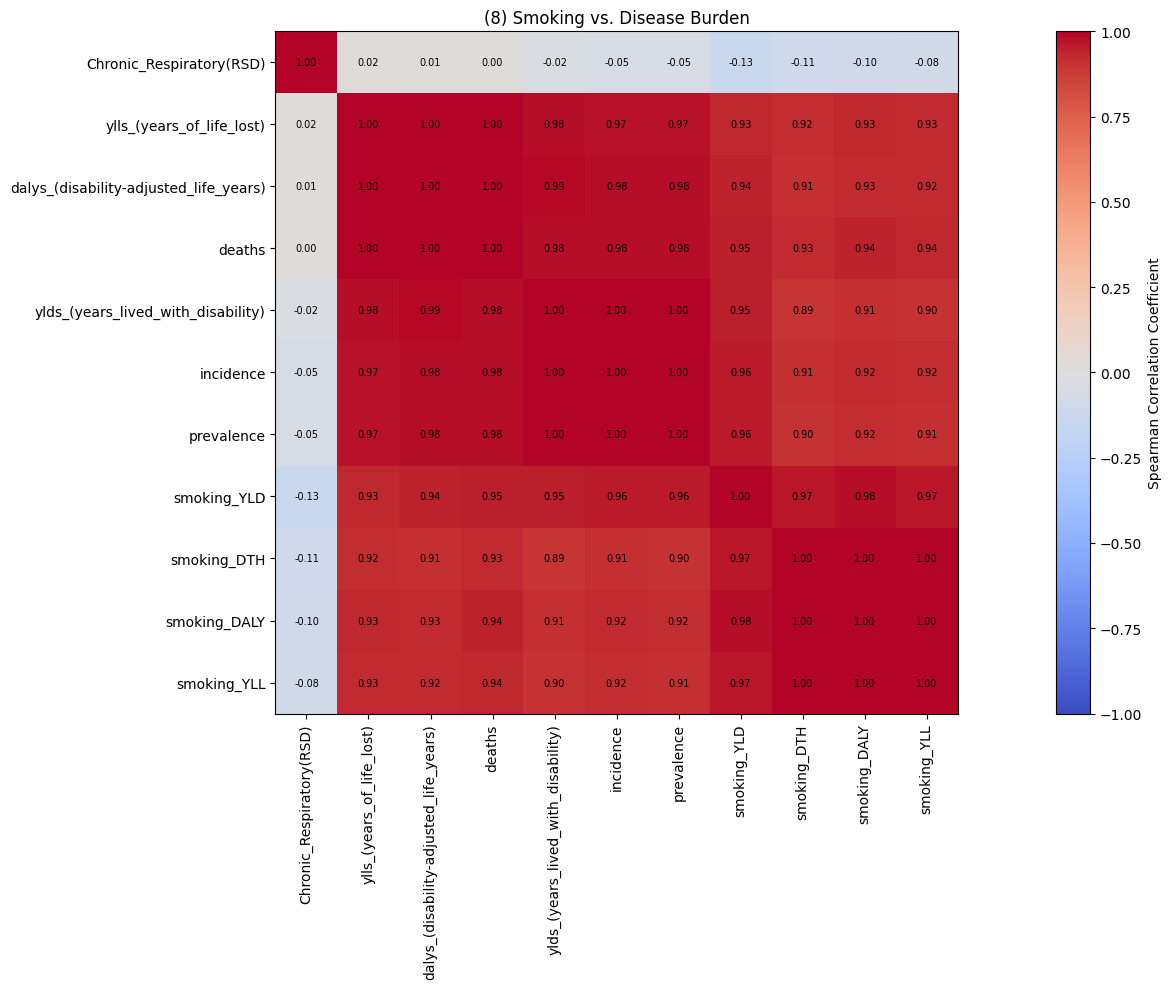

In [17]:
generate_eight_correlation_plots(merged_df)


In [18]:
### subsequent correlatio to try out


#Demographics + Disease Burden
# This subset helps illustrate broad population influences on COPD (e.g., “Does a larger, denser population correlate strongly with higher incidence or prevalence of COPD?”).
# It also shows how socioeconomic standing (e.g., GDP per capita) might relate to disease outcomes.
# Emissions + Disease Burden
# Crucial for analyzing air‐pollution impacts on COPD burden.
# Looking at correlations among PM2.5 (a known COPD trigger), CO₂, NO₂, etc., alongside incidence, DALYs, or mortality helps confirm or refute the role of pollution in respiratory outcomes.
# Healthcare Quality (HAQ_Index) + Disease Burden
# Even though HAQ_Index is sparse and covers fewer years, it can still be valuable in showing whether better healthcare access correlates with lower DALYs or mortality.
# Because it’s so limited in time coverage, its correlation matrix might look empty or have less meaning, but any strong inverse relationships with disease burden can still be important.
# Risk‐Factor‐Specific Disease Measures vs. Emissions
# Splitting out, for example, ozone_DTH or household_pollution_DALY and correlating them with ozone emissions or known household fuels can bring more granularity.
# This is particularly helpful if you want to highlight how each pollutant correlates with the corresponding risk factor measure (e.g., ozone vs. COPD from ozone pollution).
# All Variables (Full Matrix)
# Typically good for a high‐level overview.
# The downside is it can be cluttered—especially with lots of near‐duplicative measures (e.g., DALYs, YLD, YLL for each pollutant).

In [19]:
# 2. COPD Burden by Sub-Region
##############################################################################
regional_burden = (
    merged_df
    .groupby('Sub-Region')[
        ['deaths', 'ylls_(years_of_life_lost)', 'ylds_(years_lived_with_disability)']
    ]
    .mean(numeric_only=True)
    .sort_values(by='deaths', ascending=False)
)

In [23]:
 # 3. Top Countries by COPD Burden

# If your dataset column is "Country" (not "country"), adjust accordingly:
top_countries_copd = (
    merged_df
    .groupby('country')[
        ['deaths', 'ylls_(years_of_life_lost)', 'smoking_DTH', 'pm25_DTH']
        # ^ e.g. pm25_DTH means "PM2.5 Deaths." If you prefer pm25_DALY or pm25_YLD, swap accordingly.
    ]
    .mean(numeric_only=True)
    .sort_values(by='deaths', ascending=False)
    .head(10)
)

top_countries_copd

deaths  ylls_(years_of_life_lost)  smoking_DTH  pm25_DTH
country                                                                 
south africa  12278.00                  256776.05      3773.40   2379.35
nigeria       11030.80                  231242.70       797.80   2433.95
egypt          9127.35                  213128.40      3630.60   4474.30
ethiopia       7295.20                  162517.10       658.20    470.35
morocco        4668.45                   95103.30      1049.35   1050.30
kenya          4325.05                   95864.10       851.45    335.75
algeria        3606.60                   69846.65      1339.00    828.80
sudan          3591.05                   81099.10      1087.10    860.20
madagascar     2994.95                   71260.95       398.50    102.25
uganda         2706.45                   61389.90       470.35    239.05

In [26]:
# 4. Regional Time-Series Analysis
##############################################################################
# Adjust these columns to match your dataset’s actual names
region_features = [
    'Sub-Region', 
    'year', 
    'GDP PER CAPITA (USD)',          # was "GDP PER CAPITA (USD)" in your snippet
    'Population Density', 
    'Total CO2 Emission excluding LUCF (Mt)',  # was "Total CO2 Emission excluding LUCF (Mt)"
    'pm25_DTH',                # or pm25_DALY, pm25_YLD, etc.
    'smoking_DTH',            # or smoking_DALY, etc.
    'household_pollution_DTH',# or household_pollution_DALY, etc.
    'deaths',
    'ylls_(years_of_life_lost)',
    'ylds_(years_lived_with_disability)',
    'dalys_(disability-adjusted_life_years)'
]

regional_df = merged_df[region_features].copy()
regional_trends = (
    regional_df
    .groupby(['Sub-Region', 'year'])
    .mean(numeric_only=True)
    .reset_index()
)

regional_trends

Sub-Region  year  GDP PER CAPITA (USD)  Population Density  \
0   Eastern Africa  2000           1064.325625          116.541125   
1   Eastern Africa  2001           1068.562500          118.488983   
2   Eastern Africa  2002           1135.490000          120.874845   
3   Eastern Africa  2003           1219.825000          123.018826   
4   Eastern Africa  2004           1397.715000          125.371638   
..             ...   ...                   ...                 ...   
95  Western Africa  2015           1067.126667           83.261115   
96  Western Africa  2016           1060.380667           85.470724   
97  Western Africa  2017           1092.662000           87.709947   
98  Western Africa  2018           1182.369333           89.963295   
99  Western Africa  2019           1196.522667           92.241039   

    Total CO2 Emission excluding LUCF (Mt)    pm25_DTH  smoking_DTH  \
0                                 2.304444   97.529412   294.176471   
1                                 2.334444   96.764706   290.470588   
2                                 2.303333   96.235294   290.000000   
3                                 2.234444   95.235294   289.470588   
4                                 2.371667   95.176471   291.235294   
..                                     ...         ...          ...   
95                               11.096667  415.500000   178.857143   
96                               11.500667  411.500000   181.571429   
97                               11.538000  392.857143   183.928571   
98                               12.139333  373.214286   185.714286   
99                               12.924000  365.642857   188.785714   

    household_pollution_DTH       deaths  ylls_(years_of_life_lost)  \
0                971.176471  1515.941176               35054.352941   
1                965.705882  1507.470588               34818.235294   
2                972.529412  1516.882353               34985.294118   
3                979.647059  1525.882353               35209.117647   
4                993.058824  1545.235294               35649.411765   
..                      ...          ...                        ...   
95               799.857143  1781.928571               39176.071429   
96               821.214286  1817.000000               40093.285714   
97               848.142857  1846.071429               40733.214286   
98               873.571429  1872.714286               41252.785714   
99               895.071429  1904.214286               41916.642857   

    ylds_(years_lived_with_disability)  dalys_(disability-adjusted_life_years)  
0                          8917.235294                            43971.941176  
1                          9105.176471                            43923.882353  
2                          9302.058824                            44287.882353  
3                          9507.588235                            44717.352941  
4                          9725.470588                            45375.352941  
..                                 ...                                     ...  
95                        18546.142857                            57722.642857  
96                        19183.857143                            59277.642857  
97                        19880.357143                            60614.285714  
98                        20617.714286                            61871.000000  
99                        21407.000000                            63324.285714  

[100 rows x 12 columns]

In [28]:
# 5. Time-Lag Analysis (5-Year Lag for PM2.5)
##############################################################################
merged_df_sorted = merged_df.sort_values(by=['Sub-Region', 'year'])

# If you want to test PM2.5 mortality or DALYs, pick the column accordingly, e.g. pm25_DTH
merged_df_sorted['PM_Lag5'] = (
    merged_df_sorted
    .groupby('Sub-Region')['pm25_DTH']  # or pm25_DALY
    .shift(5)
)

# We correlate the 5-year-lagged PM2.5 with total DALYs
lag_corr = merged_df_sorted[['PM_Lag5', 'dalys_(disability-adjusted_life_years)']].corr().iloc[0, 1]

lag_corr

np.float64(0.25843450535243573)

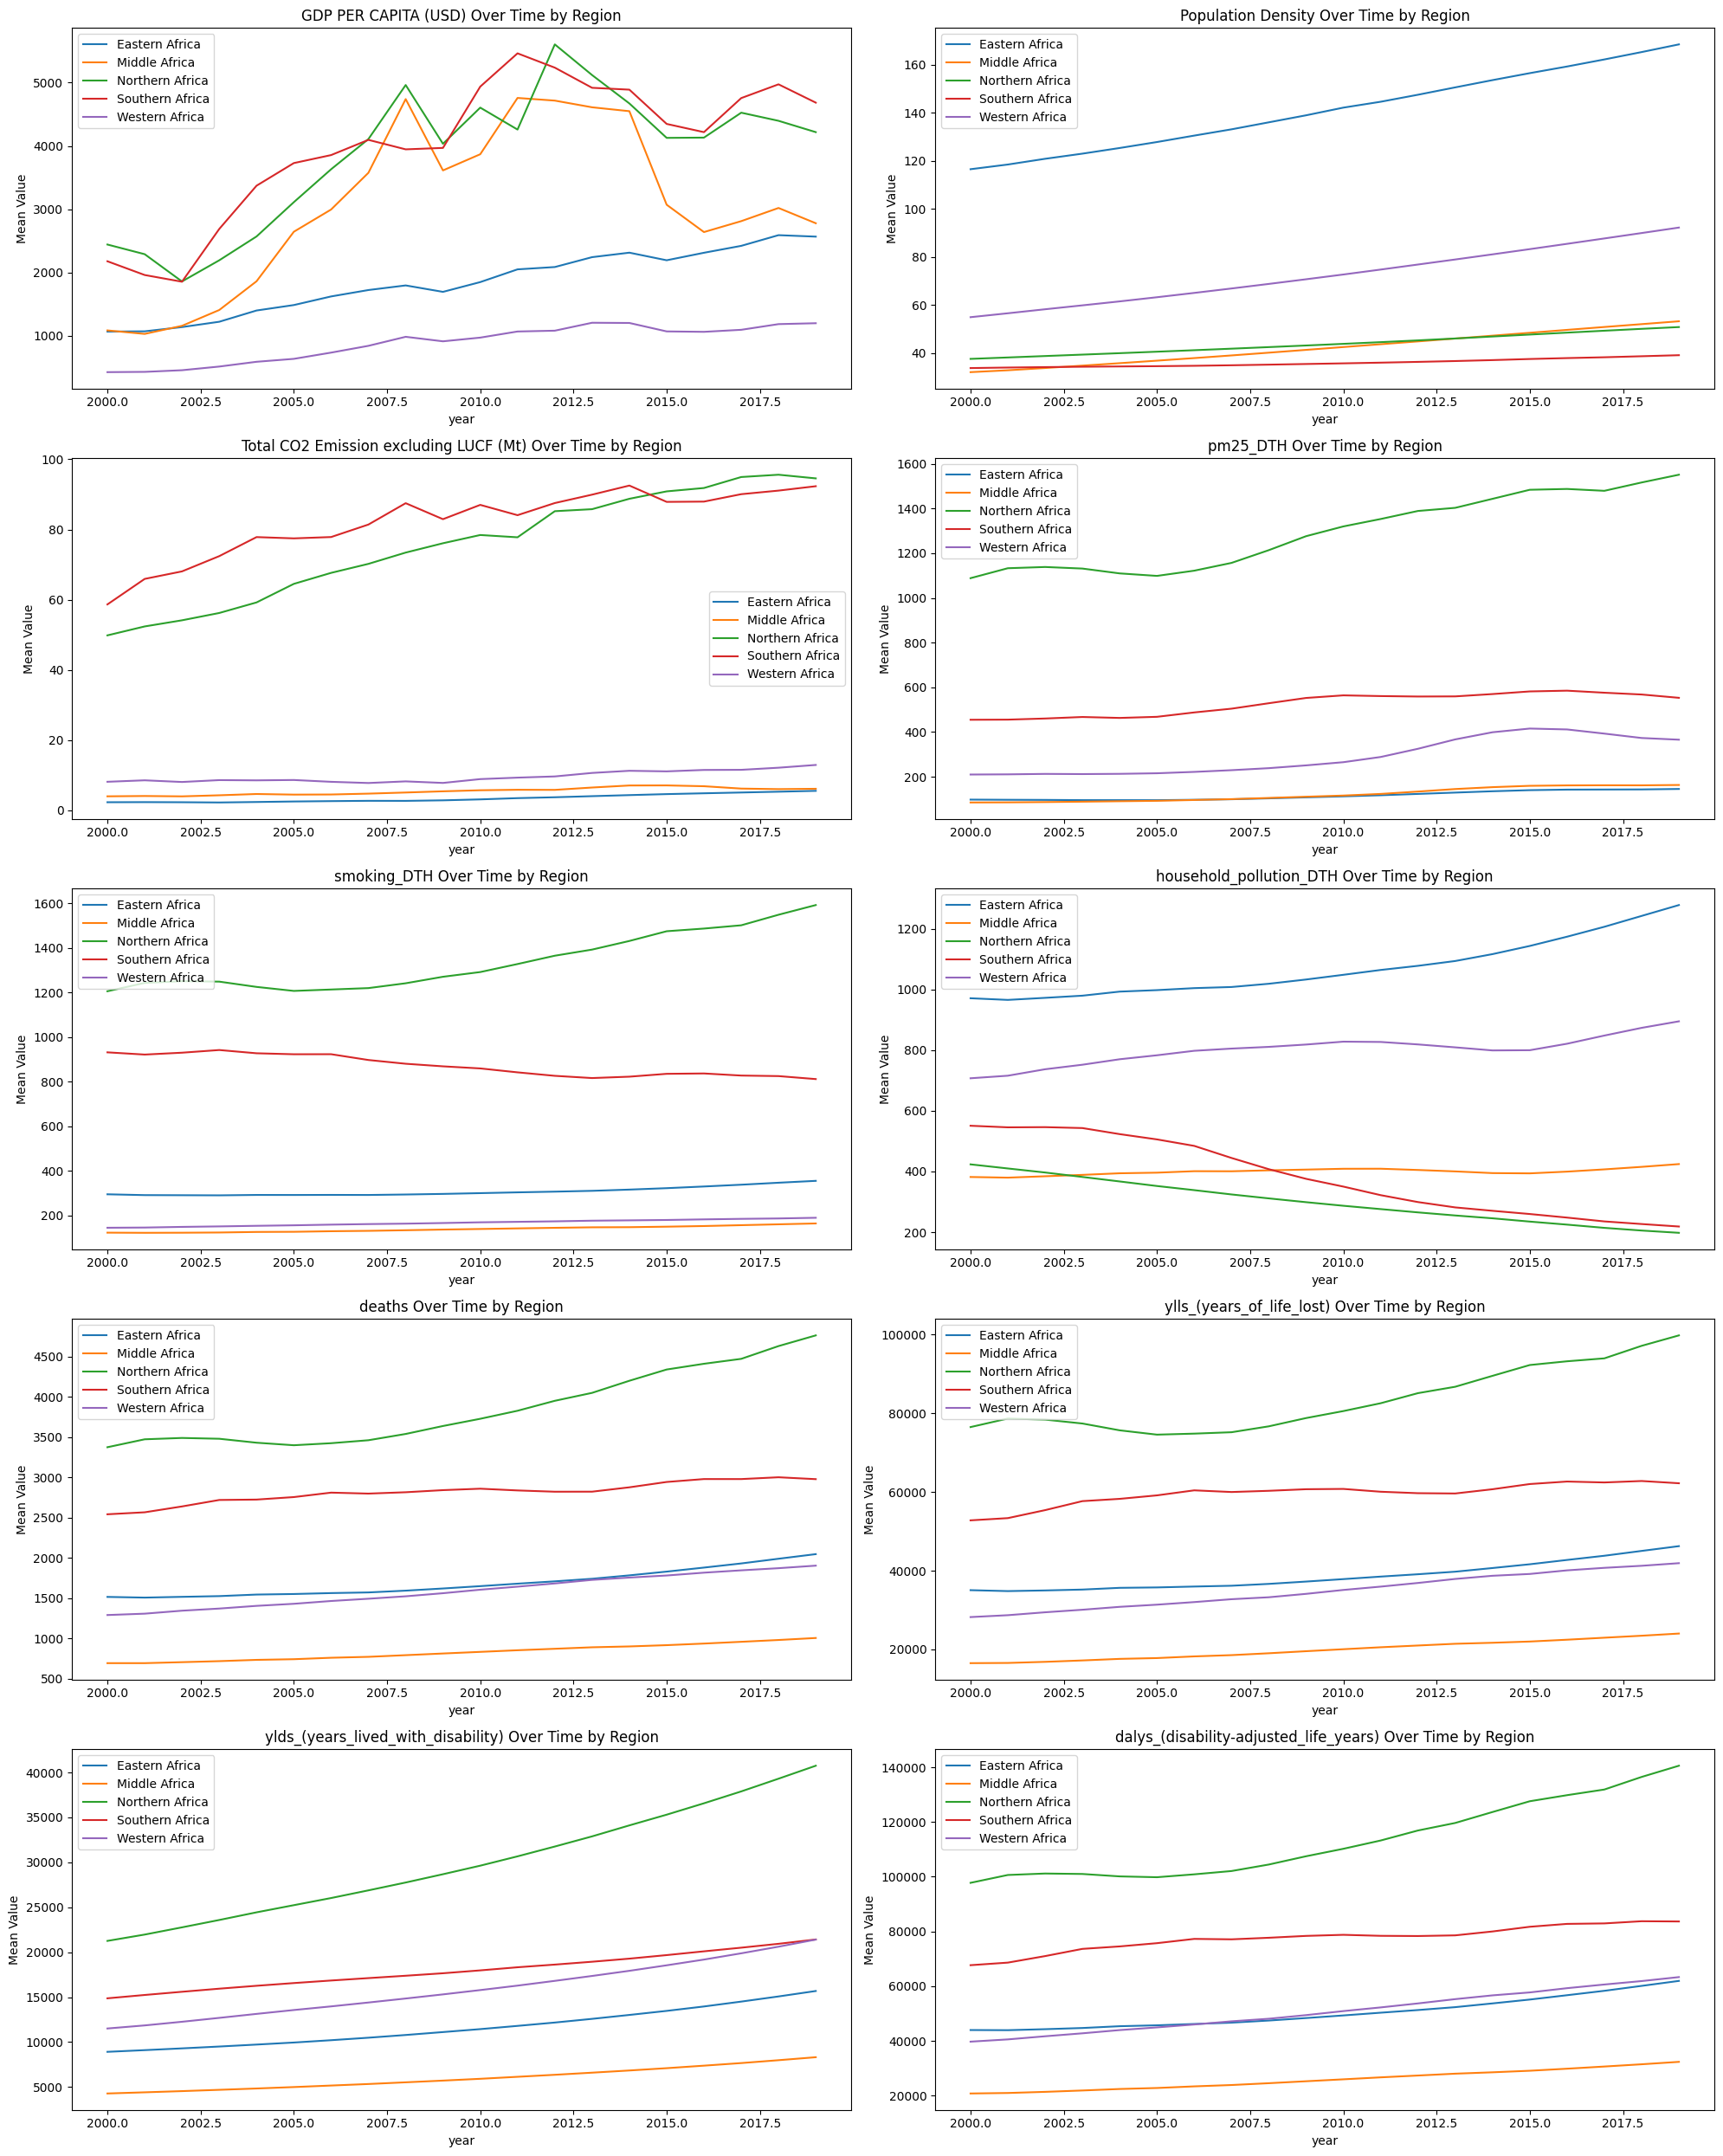

In [30]:
# 6. Visualizations
##############################################################################
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(20, 25))
axes = axes.flatten()

plot_features = [
    'GDP PER CAPITA (USD)',
    'Population Density',
    'Total CO2 Emission excluding LUCF (Mt)',
    'pm25_DTH',                # or pm25_DALY
    'smoking_DTH',            # or smoking_DALY
    'household_pollution_DTH',# or household_pollution_DALY
    'deaths',
    'ylls_(years_of_life_lost)',
    'ylds_(years_lived_with_disability)',
    'dalys_(disability-adjusted_life_years)'
]

regions = regional_trends['Sub-Region'].dropna().unique()

for i, feature in enumerate(plot_features):
    ax = axes[i]
    for region in regions:
        data = regional_trends[regional_trends['Sub-Region'] == region]
        sns.lineplot(data=data, x='year', y=feature, label=region, ax=ax)
    ax.set_title(f"{feature} Over Time by Region")
    ax.set_ylabel("Mean Value")
    ax.set_xlabel("year")
    ax.legend(loc='best')

plt.tight_layout()
plt.show()


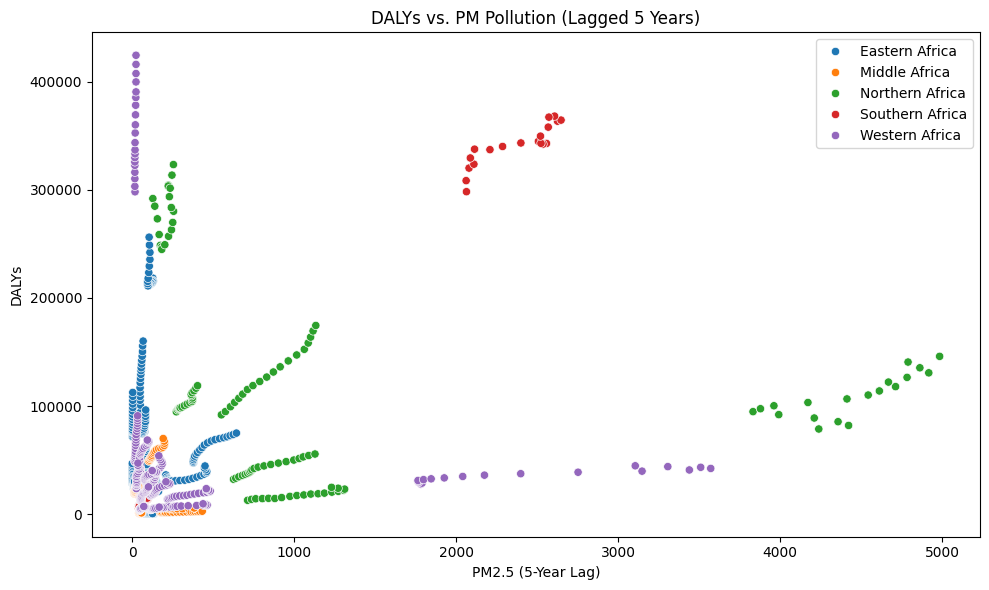

In [31]:
# 7. Lag Effect Scatterplot
##############################################################################
plt.figure(figsize=(10, 6))
sns.scatterplot(data=merged_df_sorted, x='PM_Lag5', y='dalys_(disability-adjusted_life_years)', hue='Sub-Region')
plt.title("DALYs vs. PM Pollution (Lagged 5 Years)")
plt.xlabel("PM2.5 (5-Year Lag)")
plt.ylabel("DALYs")
plt.legend()
plt.tight_layout()
plt.show()

In [35]:
# 8. Summary Tables
##############################################################################
# Example: summarizing the latest year, correlation results, missing data, etc.
latest_year = regional_trends['year'].max()
latest_summary = regional_trends[regional_trends['year'] == latest_year].set_index('Sub-Region')

lag_corr_df = pd.DataFrame({'PM Lag 5-Year Correlation with DALYs': [lag_corr]})

# If you have a missing_data_pct variable previously computed, display it:
# missing_data_pct = 100 * merged_df.isna().mean()  # Example
# For demonstration, let's define a quick placeholder:
missing_data_pct = 100 * merged_df.isna().mean()

latest_summary
lag_corr_df
missing_data_pct.to_frame

<bound method Series.to_frame of country                                    0.000000
Sub-Region                                 0.000000
year                                       0.000000
Population                                 0.000000
GDP PER CAPITA (USD)                       2.500000
Area (Km2)                                 0.000000
Population Density                         0.000000
Total CO2 Emission excluding LUCF (Mt)     0.000000
Nitrogen Oxide                             0.000000
Sulphur Dioxide                            0.000000
Carbon Monoxide                            0.000000
Organic Carbon                             0.000000
NMVOCs                                     0.000000
Black Carbon                               0.000000
Ammonia                                    0.000000
Chronic_Respiratory(RSD)                  95.288462
HAQ_Index                                 95.288462
dalys_(disability-adjusted_life_years)     5.769231
deaths                         

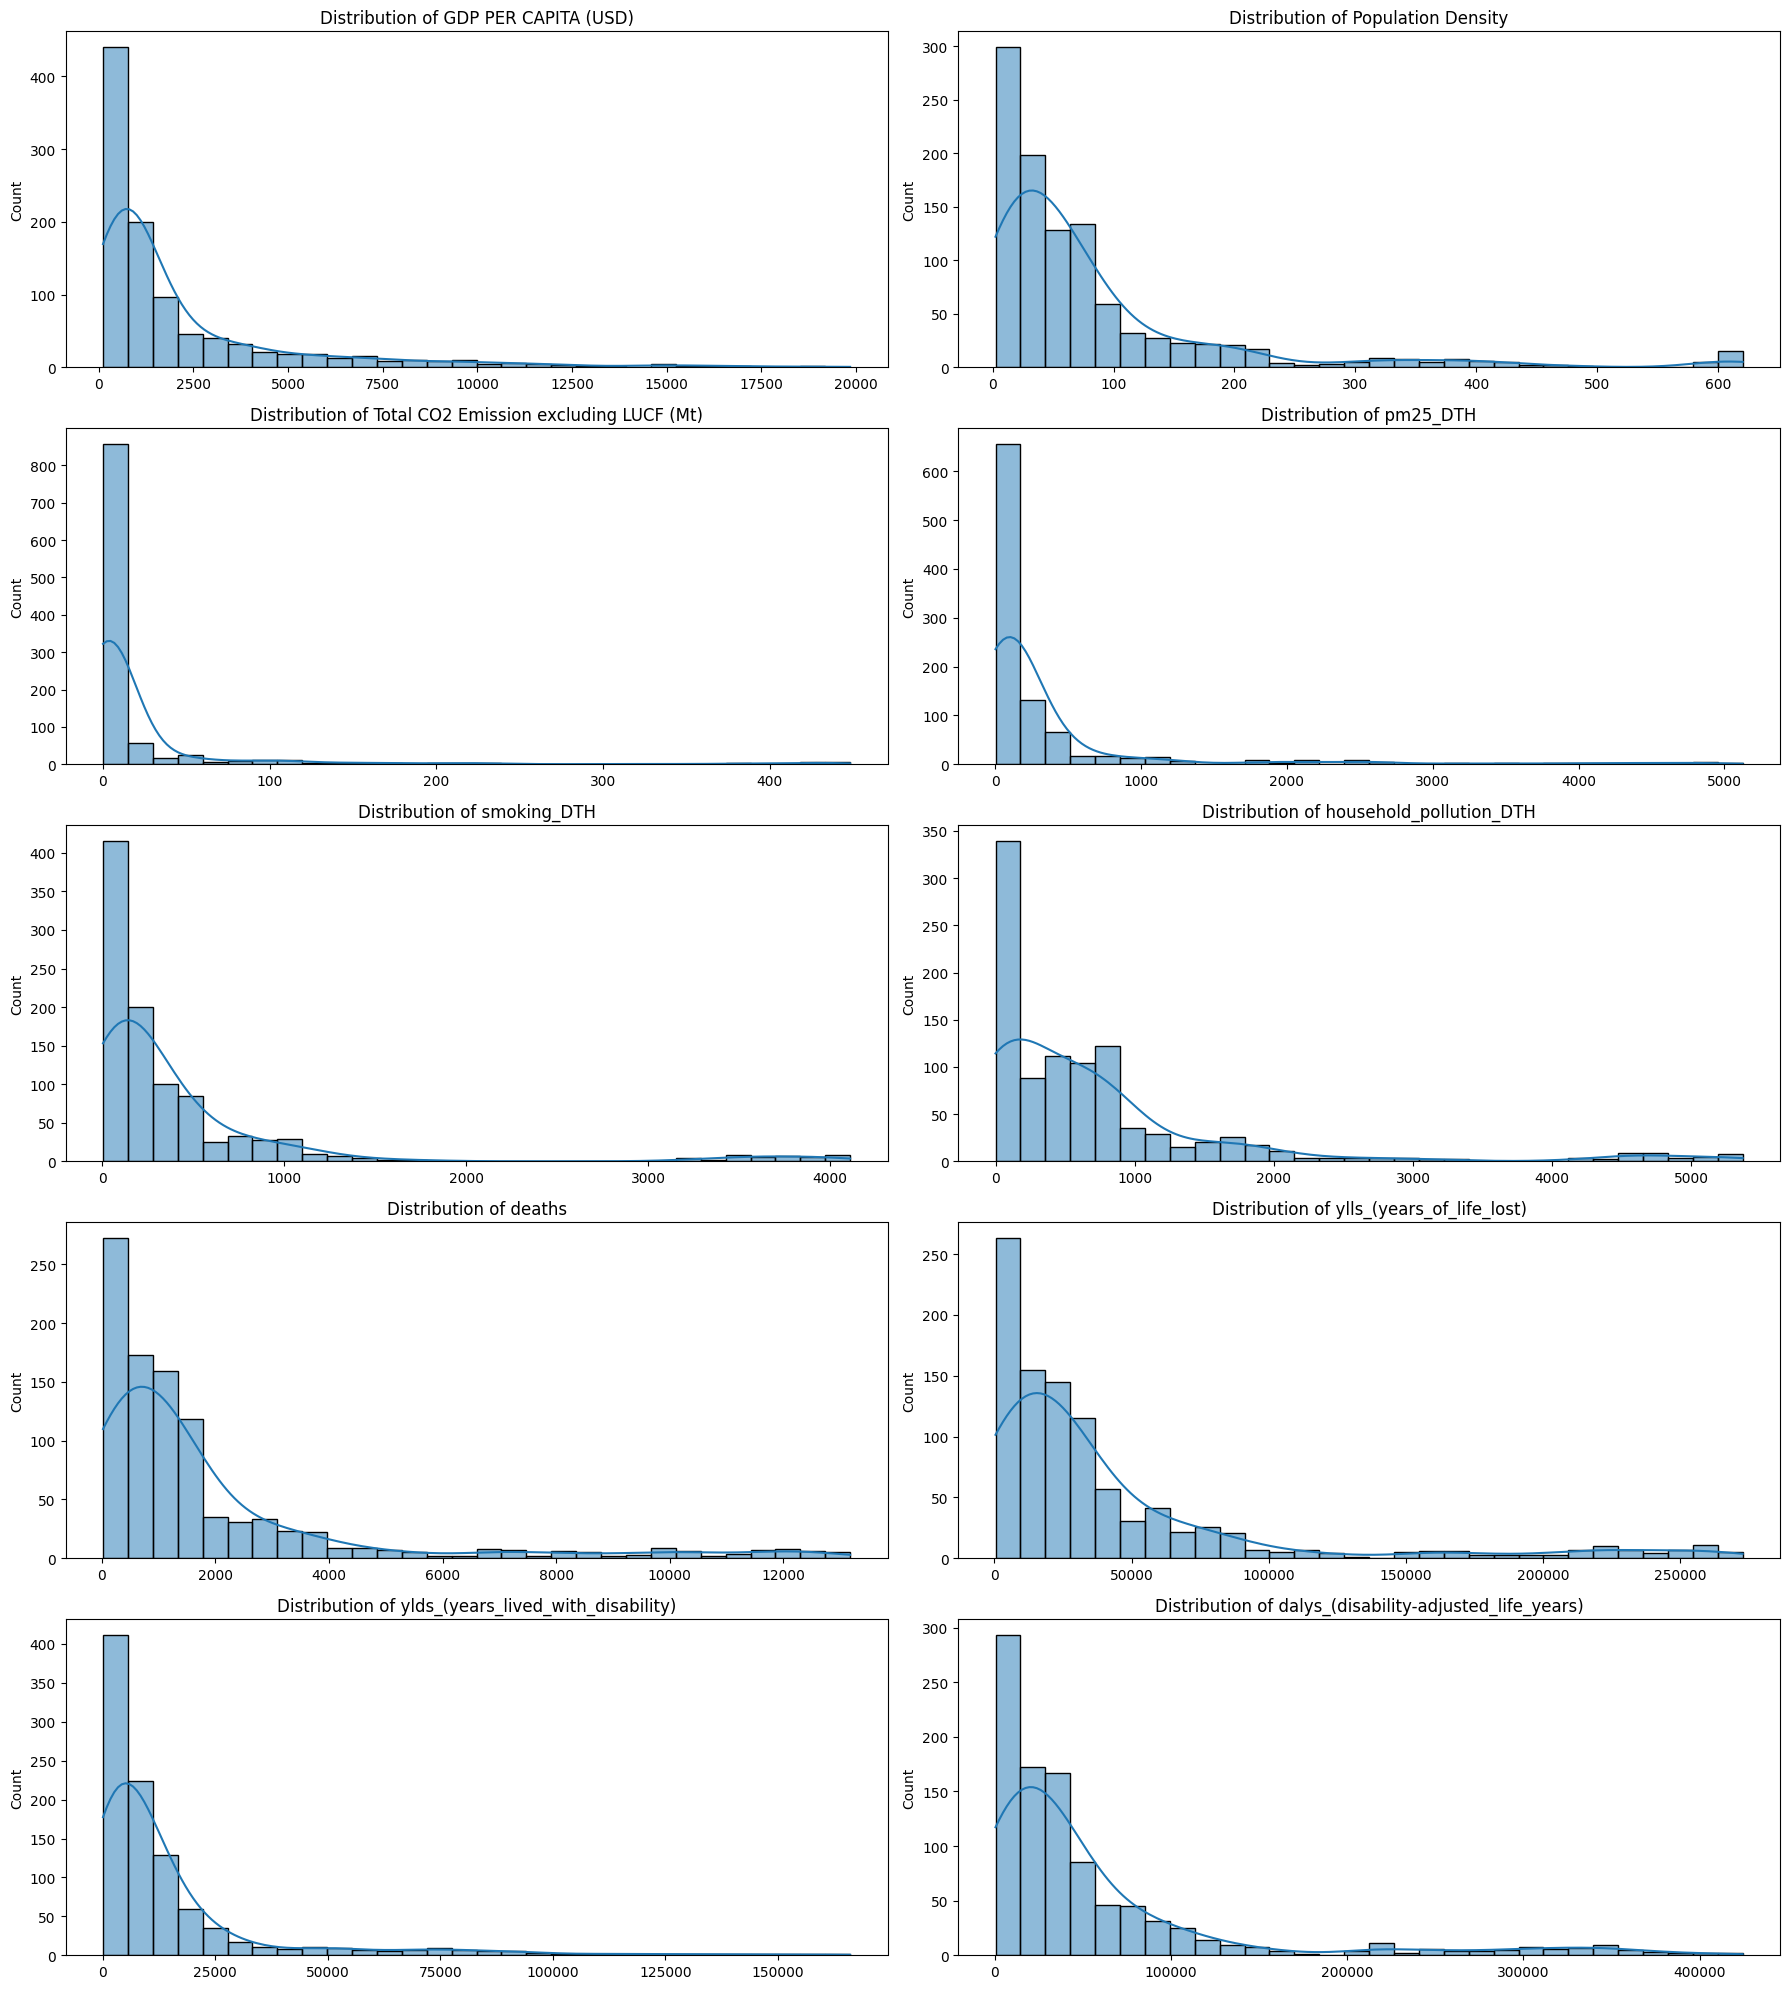

In [36]:
# 9. Histograms/KDE plots for variable shapes
##############################################################################
features_to_plot = [
    'GDP PER CAPITA (USD)',
    'Population Density',
    'Total CO2 Emission excluding LUCF (Mt)',
    'pm25_DTH',
    'smoking_DTH',
    'household_pollution_DTH',
    'deaths',
    'ylls_(years_of_life_lost)',
    'ylds_(years_lived_with_disability)',
    'dalys_(disability-adjusted_life_years)'
]

fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(18, 20))
axes = axes.flatten()

for i, feature in enumerate(features_to_plot):
    ax = axes[i]
    sns.histplot(merged_df[feature].dropna(), kde=True, ax=ax, bins=30)
    ax.set_title(f'Distribution of {feature}')
    ax.set_xlabel('')
plt.tight_layout()
plt.show()

In [38]:
# 10. Normalize COPD Burden per 100,000
##############################################################################
merged_df['DALYs_per_100k'] = (
    merged_df['dalys_(disability-adjusted_life_years)'] / merged_df['Population'] * 100000
)
merged_df['Deaths_per_100k'] = (
    merged_df['deaths'] / merged_df['Population'] * 100000
)

In [40]:
# 11. Rate of Change (Earliest–Latest Year) by Region
##############################################################################
# Dynamically detect earliest and latest year
min_year = merged_df['year'].min()
max_year = merged_df['year'].max()

rate_features = [
    'DALYs_per_100k', 'Deaths_per_100k',
    'pm25_DTH',  # or pm25_DALY
    'smoking_DTH'
]

change_df = merged_df[merged_df['year'].isin([min_year, max_year])].copy()
region_changes = change_df.groupby(['Sub-Region', 'year'])[rate_features].mean().unstack().T

region_change_pct = (
    (region_changes[max_year] - region_changes[min_year]) /
    region_changes[min_year]
) * 100


KeyError: np.int64(2019)

In [42]:
# 12. Stratified Comparison: High vs. Low Pollution
##############################################################################
# If you want to stratify by PM2.5 mortality (pm25_DTH) or concentration (pm25_DALY),
# pick the relevant column
pollution_median = merged_df['pm25_DTH'].median()  # or pm25_DALY
merged_df['Pollution_Group'] = np.where(
    merged_df['pm25_DTH'] > pollution_median, 'High PM', 'Low PM'
)

stratified_summary = merged_df.groupby('Pollution_Group')[
    ['DALYs_per_100k', 'Deaths_per_100k', 'smoking_DTH', 'household_pollution_DTH']
].mean()

stratified_summary

DALYs_per_100k  Deaths_per_100k  smoking_DTH  \
Pollution_Group                                                 
High PM              310.930360        10.471965   734.349076   
Low PM               402.972038        14.103078   122.135903   

                 household_pollution_DTH  
Pollution_Group                           
High PM                      1149.938398  
Low PM                        320.730223

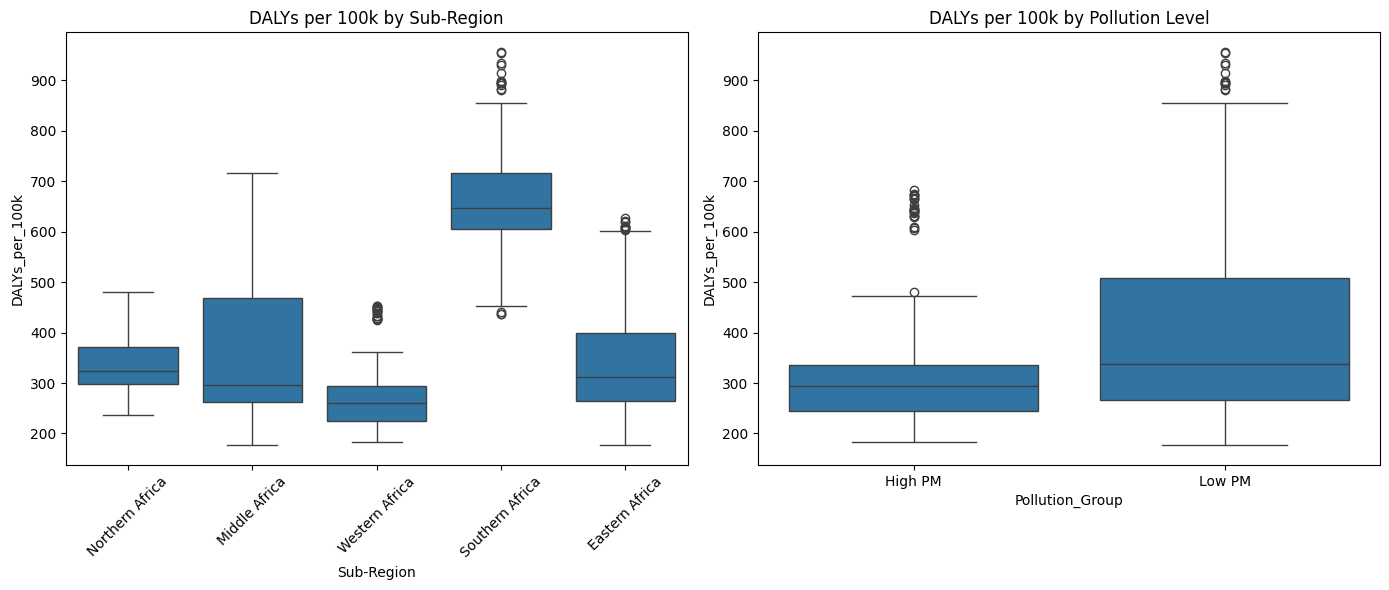

In [43]:
# 13. Boxplots of DALYs by Region & Pollution Level
##############################################################################
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.boxplot(data=merged_df, x='Sub-Region', y='DALYs_per_100k')
plt.xticks(rotation=45)
plt.title('DALYs per 100k by Sub-Region')

plt.subplot(1, 2, 2)
sns.boxplot(data=merged_df, x='Pollution_Group', y='DALYs_per_100k')
plt.title('DALYs per 100k by Pollution Level')
plt.tight_layout()
plt.show()